In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

# Setup de rutas del dataset

In [9]:
# imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
import math

# Helper para mostrar estructura de carpetas
def showDatasetStructure(baseDir):
    print("Estructura de carpetas del dataset:")
    for subset in ["train", "val", "test"]:
        path = os.path.join(baseDir, subset)
        print(f"\n{subset.upper()} -> {os.listdir(path)}")
        print(f"Total de imágenes en {subset}:")
        for cls in os.listdir(path):
            clsPath = os.path.join(path, cls)
            print(f"  {cls}: {len(os.listdir(clsPath))}")

# Main
def main():
    print("Configurando entorno en Kaggle...")
    baseDir = "/kaggle/input/chest-xray-pneumonia/chest_xray"

    # Verificar si existe la ruta base
    if not os.path.exists(baseDir):
        print("No se encontró el dataset. Asegúrate de agregarlo como input dataset.")
        return

    # Mostrar estructura general del dataset
    showDatasetStructure(baseDir)
    print("\nConfiguración completada correctamente.")

if __name__ == "__main__":
    main()

Configurando entorno en Kaggle...
Estructura de carpetas del dataset:

TRAIN -> ['PNEUMONIA', 'NORMAL']
Total de imágenes en train:
  PNEUMONIA: 3875
  NORMAL: 1341

VAL -> ['PNEUMONIA', 'NORMAL']
Total de imágenes en val:
  PNEUMONIA: 8
  NORMAL: 8

TEST -> ['PNEUMONIA', 'NORMAL']
Total de imágenes en test:
  PNEUMONIA: 390
  NORMAL: 234

Configuración completada correctamente.


# Procesamiento de imagenes

Preparando generadores de datos...
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Generadores creados correctamente.


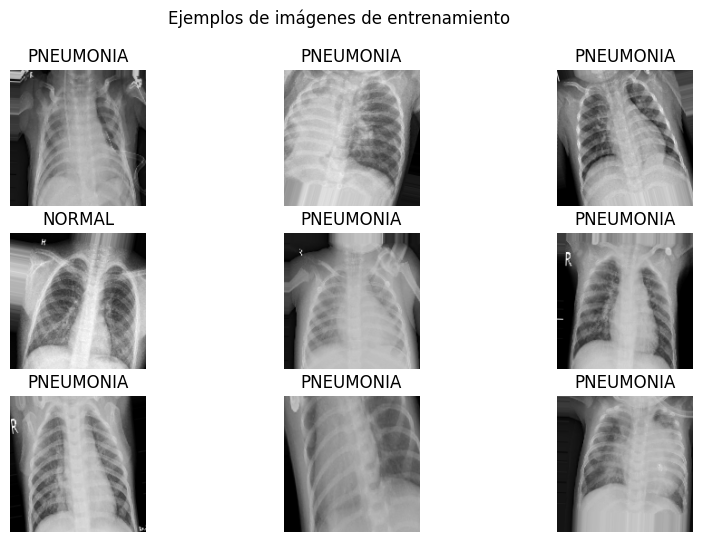

Clases detectadas: {'NORMAL': 0, 'PNEUMONIA': 1}


In [15]:
# Helper function: crea generadores de datos
def createDataGenerators(baseDir, imgSize=(150, 150), batchSize=32):
    # Aumentos para entrenamiento
    trainAug = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True
    )

    # Validación y test: solo normalización
    testAug = ImageDataGenerator(rescale=1./255)

    # Crear generadores desde carpetas
    trainGen = trainAug.flow_from_directory(
        os.path.join(baseDir, "train"),
        target_size=imgSize,
        batch_size=batchSize,
        class_mode='binary'
    )

    valGen = testAug.flow_from_directory(
        os.path.join(baseDir, "val"),
        target_size=imgSize,
        batch_size=batchSize,
        class_mode='binary'
    )

    testGen = testAug.flow_from_directory(
        os.path.join(baseDir, "test"),
        target_size=imgSize,
        batch_size=batchSize,
        class_mode='binary',
        shuffle=False
    )

    return trainGen, valGen, testGen

# Helper function: muestra ejemplos del generador
def showSampleImages(generator):
    imgs, labels = next(generator)
    plt.figure(figsize=(10, 6))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(imgs[i])
        plt.title("PNEUMONIA" if labels[i] == 1 else "NORMAL")
        plt.axis("off")
    plt.suptitle("Ejemplos de imágenes de entrenamiento")
    plt.show()

# Main
def main():
    print("Preparando generadores de datos...")
    global trainGen, valGen, testGen   # se guardan en el entorno global
    baseDir = "/kaggle/input/chest-xray-pneumonia/chest_xray"

    trainGen, valGen, testGen = createDataGenerators(baseDir)
    print("Generadores creados correctamente.")

    # Mostrar ejemplos del conjunto de entrenamiento
    showSampleImages(trainGen)

    # Mostrar clases detectadas
    print("Clases detectadas:", trainGen.class_indices)

if __name__ == "__main__":
    main()

# Definicion del modelo CNN

In [16]:
# Funcion de construccion del modelo
def buildModel(inputShape=(150, 150, 3)):
    model = Sequential()

    # Bloque 1
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=inputShape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Bloque 2
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Bloque 3
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Clasificador
    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    return model

# Compilador del modelo
def compileModel(model, lr=1e-3):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Main
def main():
    print("Construyendo modelo CNN...")
    global model 
    model = buildModel()
    model = compileModel(model)
    model.summary()

if __name__ == "__main__":
    main()

Construyendo modelo CNN...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,403,329 (20.61 MB)

 Trainable params: 5,402,625 (20.61 MB)

 Non-trainable params: 704 (2.75 KB)

# Entrenamiento del modelo

In [20]:
# Helper function: solicita un entero válido al usuario
def getIntInput(prompt, default=10):
    # validation loop
    while True:
        try:
            val = input(f"{prompt} [por defecto {default}]: ").strip()
            if val == "":
                return int(default)
            num = int(val)
            if num <= 0:
                print("Invalid input, please enter a numerical value mayor que 0")
                continue
            return num
        except ValueError:
            print("Invalid input, please enter a numerical value")

# Helper function: entrena el modelo con los generadores
def trainModel(model, trainGen, valGen, epochs=10):
    # Compute steps to avoid partial batches issues
    stepsPerEpoch = max(1, trainGen.samples // trainGen.batch_size)
    validationSteps = max(1, valGen.samples // valGen.batch_size)

    print(f"Entrenando por {epochs} épocas")
    print(f"steps_per_epoch={stepsPerEpoch}, validation_steps={validationSteps}")

    # Train simple training loop
    history = model.fit(
        trainGen,
        epochs=epochs,
        validation_data=valGen,
        steps_per_epoch=stepsPerEpoch,
        validation_steps=validationSteps
    )

    return history

# Main
def main():
    print("Inicio de la sección de entrenamiento.")
    # Ask for epochs interactively
    epochs = getIntInput("Introduce el número de épocas para entrenar", default=10)

    # Validate that required objects exist in global scope
    if 'model' not in globals():
        print("No se encontró la variable 'model'. Asegúrate de ejecutar la celda de definición del modelo antes.")
        return
    if 'trainGen' not in globals() or 'valGen' not in globals():
        print("No se encontraron 'trainGen' y/o 'valGen'. Ejecuta la celda donde creaste los generadores de datos.")
        return

    # Retrieve objects
    model_local = globals()['model']
    train_gen_local = globals()['trainGen']
    val_gen_local = globals()['valGen']

    # Train
    global history
    history = trainModel(model_local, train_gen_local, val_gen_local, epochs=epochs)

    # Summary of results
    print("Entrenamiento finalizado.")
    print("Historial de entrenamiento (claves):", list(history.history.keys()))

if __name__ == "__main__":
    main()

Inicio de la sección de entrenamiento.


Introduce el número de épocas para entrenar [por defecto 10]:  1


Entrenando por 1 épocas
steps_per_epoch=163, validation_steps=1
163/163 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.9547 - loss: 0.1283 - val_accuracy: 0.5000 - val_loss: 4.7867
Entrenamiento finalizado.
Historial de entrenamiento (claves): ['accuracy', 'loss', 'val_accuracy', 'val_loss']


# Graficas de perdida y precision

Visualizando resultados del entrenamiento...


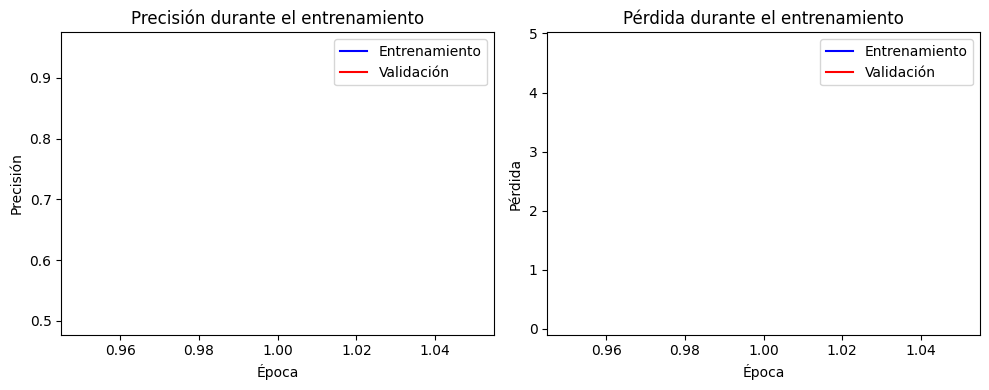

Visualización completada.


In [21]:
# Helper function: grafica las curvas de entrenamiento
def plotTrainingHistory(history):
    # Extrae métricas
    acc = history.history['accuracy']
    valAcc = history.history['val_accuracy']
    loss = history.history['loss']
    valLoss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Gráfico de precisión
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Entrenamiento')
    plt.plot(epochs, valAcc, 'r-', label='Validación')
    plt.title('Precisión durante el entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.legend()

    # Gráfico de pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Entrenamiento')
    plt.plot(epochs, valLoss, 'r-', label='Validación')
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Main
def main():
    print("Visualizando resultados del entrenamiento...")
    if 'history' not in globals():
        print("No se encontró la variable 'history'. Ejecuta la celda de entrenamiento antes.")
        return

    plotTrainingHistory(history)
    print("Visualización completada.")

if __name__ == "__main__":
    main()

# Evaluacion con el conjunto de test

Evaluando modelo con el conjunto de test...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 589ms/step - accuracy: 0.7007 - loss: 1.9612

Pérdida en test: 4.1812
Precisión en test: 0.3846
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 409ms/step


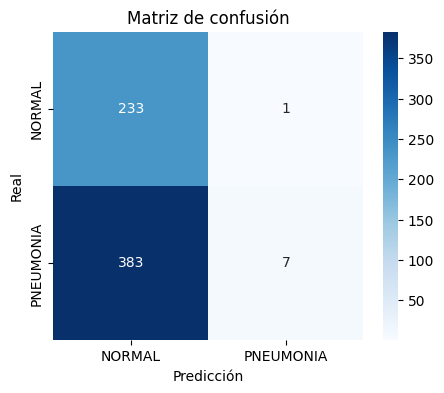


Reporte de clasificación:
              precision    recall  f1-score   support

      NORMAL       0.38      1.00      0.55       234
   PNEUMONIA       0.88      0.02      0.04       390

    accuracy                           0.38       624
   macro avg       0.63      0.51      0.29       624
weighted avg       0.69      0.38      0.23       624



In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Helper function: evalúa el modelo en el conjunto de test
def evaluateModel(model, testGen):
    print("Evaluando modelo con el conjunto de test...")
    
    # Evalúa el modelo
    loss, acc = model.evaluate(testGen, verbose=1)
    print(f"\nPérdida en test: {loss:.4f}")
    print(f"Precisión en test: {acc:.4f}")

    # Predicciones
    preds = model.predict(testGen, verbose=1)
    yPred = (preds > 0.5).astype(int).ravel()
    yTrue = testGen.classes

    # Matriz de confusión
    cm = confusion_matrix(yTrue, yPred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["NORMAL", "PNEUMONIA"],
                yticklabels=["NORMAL", "PNEUMONIA"])
    plt.title("Matriz de confusión")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

    # Reporte detallado
    print("\nReporte de clasificación:")
    print(classification_report(yTrue, yPred, target_names=["NORMAL", "PNEUMONIA"]))

# Main
def main():
    if 'model' not in globals() or 'testGen' not in globals():
        print("Asegúrate de haber entrenado el modelo y creado los generadores antes.")
        return

    evaluateModel(model, testGen)

if __name__ == "__main__":
    main()

# Visualizacion de predicciones individuales

Mostrando 12 predicciones del conjunto de test...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


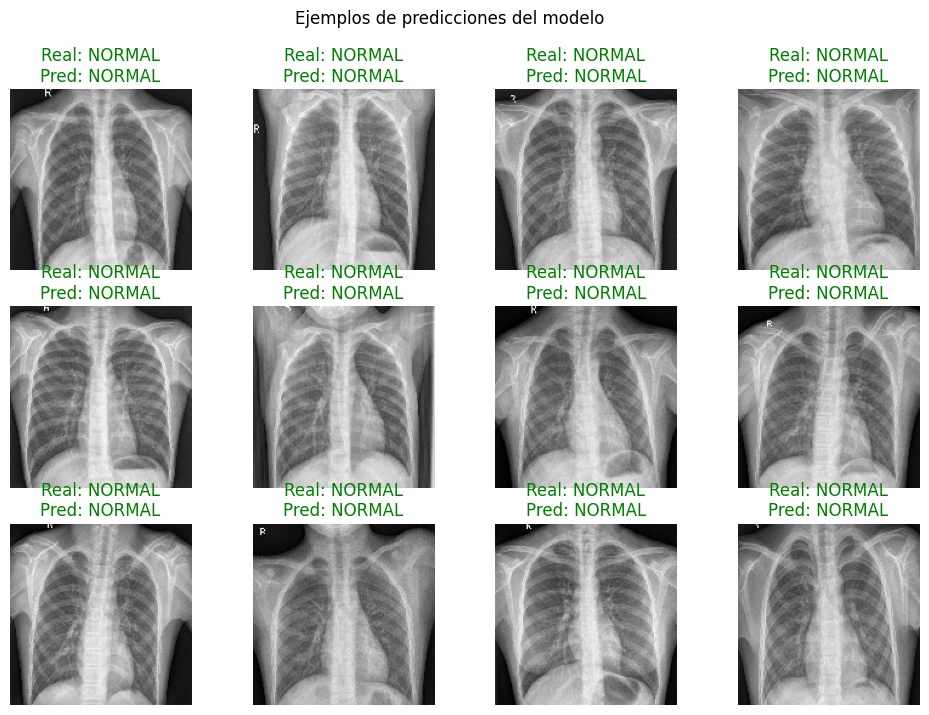

In [24]:
# Helper function: muestra predicciones del modelo
def showPredictions(model, testGen, n=12):
    print(f"Mostrando {n} predicciones del conjunto de test...")

    # Obtener imágenes y etiquetas
    imgs, labels = next(testGen)
    preds = model.predict(imgs)
    preds = (preds > 0.5).astype(int).ravel()

    plt.figure(figsize=(12, 8))
    for i in range(n):
        plt.subplot(3, 4, i + 1)
        plt.imshow(imgs[i])
        trueLabel = "PNEUMONIA" if labels[i] == 1 else "NORMAL"
        predLabel = "PNEUMONIA" if preds[i] == 1 else "NORMAL"

        color = "green" if trueLabel == predLabel else "red"
        plt.title(f"Real: {trueLabel}\nPred: {predLabel}", color=color)
        plt.axis("off")
    plt.suptitle("Ejemplos de predicciones del modelo")
    plt.show()

# Main
def main():
    if 'model' not in globals() or 'testGen' not in globals():
        print("Asegúrate de haber entrenado el modelo y creado los generadores antes.")
        return

    # Reinicia el generador para tomar nuevas imágenes
    testGen.reset()

    showPredictions(model, testGen, n=12)

if __name__ == "__main__":
    main()